# Revisit of the biclosed module

## Biclosed types

Biclosed types are trees generated by tensor, Over, Under. We subclass monoidal.Ty for the tensor.

In [1]:
from discopy import monoidal

class Ty(monoidal.Ty):
    @staticmethod
    def upgrade(old):
        if len(old) == 1 and isinstance(old[0], (Over, Under)):
            return old[0]
        return Ty(*old.objects)
        
    def __init__(self, *objects, left=None, right=None):
        self.left, self.right = left, right
        super().__init__(*objects)

    def __lshift__(self, other):
        return Over(self, other)

    def __rshift__(self, other):
        return Under(self, other)

    def __matmul__(self, other):
        return Ty(*(self.tensor(other)))


class Over(Ty):
    """ Forward slash types. """
    def __init__(self, left=None, right=None):
        Ty.__init__(self, self, left=left, right=right)

    def __repr__(self):
        return "Over({}, {})".format(repr(self.left), repr(self.right))

    def __str__(self):
        return "({} << {})".format(self.left, self.right)

    def __eq__(self, other):
        if not isinstance(other, Over):
            return False
        return self.left == other.left and self.right == other.right


class Under(Ty):
    """ Backward slash types. """
    def __init__(self, left=None, right=None):
        Ty.__init__(self, self, left=left, right=right)

    def __repr__(self):
        return "Under({}, {})".format(repr(self.left), repr(self.right))

    def __str__(self):
        return "({} >> {})".format(self.left, self.right)

    def __eq__(self, other):
        if not isinstance(other, Under):
            return False
        return self.left == other.left and self.right == other.right

In [2]:
x = Ty('x')
assert x >> x << x == Over(Under(Ty('x'), Ty('x')), Ty('x'))
assert x >> (x << x) == Under(Ty('x'), Over(Ty('x'), Ty('x')))
x0, x1, y0, y1, m = Ty('x0'), Ty('x1'), Ty('y0'), Ty('y1'), Ty('m')
comb = (x0 >> m @ y0) @ ( m @ x1 >> y1)
lens = (x0 >> (y0 >> x) >> y1)

We draw a tree representation of the type by interfacing with operad.Tree

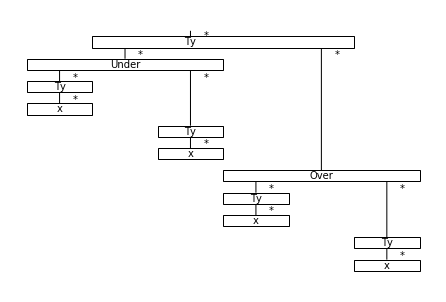

In [3]:
from discopy.operad import Box, Ob, tree2diagram

star = Ob('*')
UNDER = Box('Under', star, [star, star])
OVER = Box('Over', star, [star, star])
TY = lambda n: Box('Ty', star, n * [star])

def to_tree(ty):
    if isinstance(ty, Over):
        return OVER(to_tree(ty.left), to_tree(ty.right))
    if isinstance(ty, Under):
        return UNDER(to_tree(ty.left), to_tree(ty.right))
    if isinstance(ty, Ty):
        n = len(ty.objects)
        return TY(n)(*map(to_tree, ty.objects))
    if isinstance(ty, Ob):
        return Box(ty.name, star, [])
    raise NotImplementedError()

tree2diagram(to_tree((x >> x) @ (x << x))).draw()

## Biclosed diagrams

Biclosed diagrams, i.e. arrows in free biclosed categories, are monoidal diagrams with two extra methods for currying and uncurrying, packaged into classes.

In [4]:
from discopy import monoidal

@monoidal.Diagram.subclass
class Diagram(monoidal.Diagram):
    """ Diagrams in a biclosed monoidal category. """

    def curry(self, n_wires=1, left=False):
        """ Diagram currying. """
        return Curry(self, n_wires, left)

    def uncurry(self):
        """ Diagram uncurrying. """
        return UnCurry(self)

class Id(monoidal.Id, Diagram):
    """ Identity diagram in a biclosed monoidal category. """


class Box(monoidal.Box, Diagram):
    """ Boxes in a biclosed monoidal category. """

    
class Curry(Box):
    """
    Curried diagram.
    """
    def __init__(self, diagram, n_wires=1, left=False):
        name = "Curry({})".format(diagram)
        if left:
            dom = diagram.dom[n_wires:]
            cod = diagram.dom[:n_wires] >> diagram.cod
        else:
            dom = diagram.dom[:-n_wires]
            cod = diagram.cod << diagram.dom[-n_wires or len(diagram.dom):]
        self.diagram, self.n_wires, self.left = diagram, n_wires, left
        super().__init__(name, dom, cod)
        
    def __repr__(self):
        return "Curry({}, n_wires={}, left={})".format(self.diagram, self.n_wires, self.left)


class UnCurry(Box):
    """
    Un-Curried diagram.
    """
    def __init__(self, diagram):
        name = "UnCurry({})".format(diagram)
        self.diagram = diagram
        if isinstance(diagram.cod, Over):
            dom = diagram.dom @ diagram.cod.right
            cod = diagram.dom.left
            super().__init__(name, dom, cod)
        elif isinstance(diagram.cod, Under):
            dom = diagram.dom.left @ diagram.dom
            cod = diagram.dom.right
            super().__init__(name, dom, cod)
        else:
            super().__init__(name, diagram.dom, diagram.cod)
            
    def __repr__(self):
        return "UnCurry({})".format(self.diagram)

In [5]:
x, y, z = Ty('x'), Ty('y'), Ty('z')

Curry(Id(x))

Curry(Id(x), n_wires=1, left=False)

## Categorial grammar

We recover the rules of categorial grammars (in historical order) by constructing them from the free biclosed category with no generators.

In [6]:
# Adjiuciewicz

FA = lambda a, b: UnCurry(Id(a >> b))
assert FA(x, y).dom == x @ (x >> y) and FA(x, y).cod == y

BA = lambda a, b: UnCurry(Id(b << a))
assert BA(x, y).dom == (y << x) @ x and BA(x, y).cod == y


# Lambek

proofFC = FA(x, y) @ Id(y >> z) >> FA(y, z)
FC = Curry(proofFC, left=True)
assert FC.dom == (x >> y) @ (y >> z) and FC.cod == (x >> z)

BC = Curry(Id(x << y) @ BA(z, y) >> BA(y, x))
assert BC.dom == (x << y) @ (y << z) and BC.cod == (x << z)

TYR = Curry(UnCurry(Id(x >> y)))
assert TYR.dom == x and TYR.cod == (y << (x >> y))


# Steedman

Swap = lambda a, b: Box('Swap', a @ b, b @ a)
proofBX = Id(x << y) @ (Swap(z >> y, z) >> FA(z, y)) >> BA(y, x)
BX = Curry(proofBX)
assert BX.dom == (x << y) @ (z >> y) and BX.cod == (x << z)

proofFX = (Swap(x, y << x) >> BA(x, y)) @ Id(y >> z) >> FA(y, z)
FX = Curry(proofFX, left=True)
assert FX.dom == (y << x) @ (y >> z) and FX.cod == (x >> z)

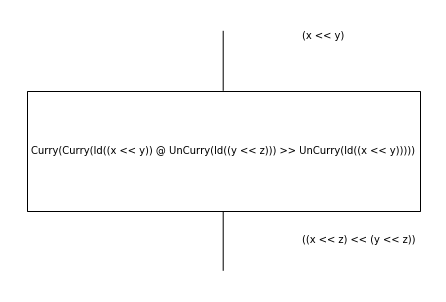

In [7]:
BC.curry().draw()

Proof trees for FC and BX


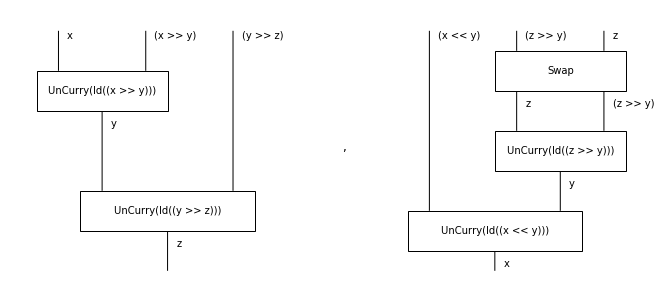

In [8]:
from discopy import drawing
print('Proof trees for FC and BX')
drawing.equation(proofFC, proofBX, symbol=',', figsize=(9, 4))

## Functors from free biclosed categories

In [9]:
class Functor(monoidal.Functor):
    def __init__(self, ob, ar, cod=(Ty, Diagram)):
        self.cod = cod
        super().__init__(ob, ar, ob_factory=cod[0], ar_factory=cod[1])

    def __call__(self, diagram):
        if isinstance(diagram, Over):
            return self(diagram.left) << self(diagram.right)
        if isinstance(diagram, Under):
            return self(diagram.left) >> self(diagram.right)
        if isinstance(diagram, Ty) and len(diagram) > 1:
            return self.cod[0].tensor(*[
                self(diagram[i: i + 1]) for i in range(len(diagram))])
        if isinstance(diagram, Id):
            return self.cod[1].id(self(diagram.dom))
        if isinstance(diagram, Curry):
            n_wires = len(self(getattr(
                diagram.cod, 'left' if diagram.left else 'right')))
            return self.cod[1].curry(
                self(diagram.diagram), n_wires, diagram.left)
        if isinstance(diagram, UnCurry):
            return self.cod[1].uncurry(self(diagram.diagram))
        return super().__call__(diagram)

##  We give semantics to categorial grammars in the category of functions


In [77]:
class Function(Box):
    def __init__(self, inside, dom, cod):
        self.inside = inside
        name = "Function({}, {}, {})".format(inside, dom, cod)
        super().__init__(name, dom, cod)

    def then(self, other):
        inside = lambda *xs: other(*tuple(self(*xs)))
        return Function(inside, self.dom, other.cod)

    def tensor(self, other):
        def inside(*xs):
            left, right = xs[:len(self.dom)], xs[len(self.dom):]
            print(left, right, self(*left), other(*right))
            result = tuple(self(*left)) + tuple(other(*right))
            return (result[0], ) if len(self.cod @ other.cod) == 1 else result
        return Function(inside, self.dom @ other.dom, self.cod @ other.cod)

    def __call__(self, *xs): return self.inside(*xs)

    @staticmethod
    def id(x):
        return Function(lambda *xs: xs, x, x)

    @staticmethod
    def copy(x):
        return Function(lambda *xs: (*xs, *xs), x, x @ x)
    
    @staticmethod
    def delete(x):
        return Function(lambda *xs: (), x, Ty())
    
    @staticmethod
    def swap(x, y):
        return Function(lambda x0, y0: (y0, x0), x @ y, y @ x)
    
    @staticmethod
    def curry(diagram, n_wires=1, left=False):
        if not left:
            dom = diagram.dom[:-n_wires]
            cod = diagram.cod << diagram.dom[-n_wires:]
            inside = lambda *xl: lambda *xr: diagram.inside(*(xl + xr))
            return Function(inside, dom, cod)
        else:
            dom = diagram.dom[n_wires:]
            cod = diagram.dom[:n_wires] >> diagram.cod
            inside = lambda *xl: lambda *xr: diagram.inside(*(xl + xr))
            return Function(inside, dom, cod)
    
    @staticmethod
    def uncurry(diagram):
        if isinstance(diagram.cod, Over):
            left, right = diagram.cod.left, diagram.cod.right
            cod = left
            dom = diagram.dom @ right
            inside = lambda *xs: diagram.inside(*xs[:len(diagram.dom)])(*xs[len(diagram.dom):])
            return Function(inside, dom, cod)
        elif isinstance(diagram.cod, Under):
            left, right = diagram.cod.left, diagram.cod.right
            cod = right
            dom = left @ diagram.dom
            inside = lambda *xs: diagram.inside(*xs[len(left):])(*xs[:len(left)])
            return Function(inside, dom, cod)
        return diagram

In [78]:
X = Ty('X')

two, three, five = Box('two', Ty(), X), Box('three', Ty(), X), Box('five', Ty(), X)
plus, is_ = Box('plus', X @ X, X), Box('is', X @ X, X)
sentence = two @ three @ five >> plus @ Id(X) >> is_

number = lambda y: Function(lambda: (y, ), Ty(), X)
add = Function(lambda x, y: (x + y,), X @ X, X)
is_equal = Function(lambda x, y: (x == y, ), X @ X, X)

ob = lambda x: x
ar = {two: number(2), three: number(3), five: number(5),
      is_: is_equal, plus: add}
F = Functor(ob, ar, cod=(Ty, Function))
F(sentence)()

() () () (2,)
() () (2,) ()
() () () (2,)
(2,) () (2,) (3,)
(2,) () (2, 3) ()
(2,) () (2,) (3,)
(2, 3) () (2, 3) (5,)
(2, 3) () (2, 3, 5) ()
(2, 3) () (2, 3) (5,)
() (2, 3) () (5,)
(2, 3) (5,) (5,) (5,)
() (2, 3) () (5,)
() (5, 5) () (True,)
(5, 5) () (True,) ()
() (5, 5) () (True,)


(True,)

In [79]:
n, s = Ty('N'), Ty('S')

bruno, shakespeare = Box('Bruno', Ty(), n), Box('Shakespeare', Ty(), n)
did = Box('did', Ty(), n >> (s << (s << n)))
noot = Box('not', Ty(), (s << n) << (n >> s))
meet = Box('meet', Ty(), (n >> s) << n)

In [80]:
FA = lambda a, b: UnCurry(Id(a >> b))
# assert FA(x, y).dom == x @ (x >> y) and FA(x, y).cod == y
BA = lambda a, b: UnCurry(Id(b << a))
# assert BA(x, y).dom == (y << x) @ x and BA(x, y).cod == y
FC = lambda x, y, z: Curry(FA(x, y) @ Id(y >> z) >> FA(y, z), left=True)
# assert FC.dom == (x >> y) @ (y >> z) and FC.cod == (x >> z)
BC = lambda x, y, z: Curry(Id(x << y) @ BA(z, y) >> BA(y, x))
# assert BC.dom == (x << y) @ (y << z) and BC.cod == (x << z)

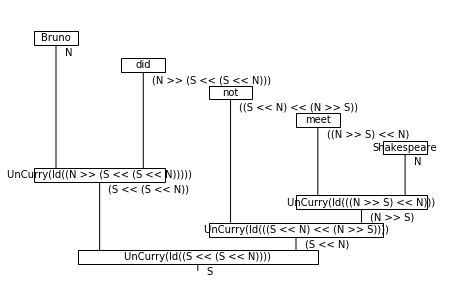

In [81]:
diagram = bruno @ did @ noot @ meet @ shakespeare >> FA(n, s << (s << n)) @ Id(noot.cod) @ BA(n, n >> s)
(diagram >> Id(s << (s << n)) @ BA(n >> s, s << n) >> BA(s << n, s)).draw()

In [82]:
ob = lambda x: x
ar = {bruno: Function(lambda: ('Bruno',), Ty(), n), shakespeare: Function(lambda: ('Shakespeare',), Ty(), n), 
      meet: Function.curry(Function.curry(Function(lambda *xs: (xs[0] == xs[1],), n @ n, s), left=True))}
F = Functor(ob, ar, cod=(Ty, Function))

In [84]:
sentence = bruno @ meet @ shakespeare >> Id(n) @ BA(n, n >> s) >> FA(n, s)

F(meet)()

<function __main__.Function.curry.<locals>.<lambda>.<locals>.<lambda>(*xr)>